In [1]:
%matplotlib inline
import argparse
import numpy as np
import math
import matplotlib.pyplot as plt

from datetime import datetime
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import os
from PIL import Image
from tqdm.notebook import tqdm
cuda = torch.device('cuda:0')

In [2]:
import pickle
import pandas as pd
import os
from skimage.io import imread
from  torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms

In [3]:
import re

In [4]:
import sys
sys.path.append("..")
from utils.CUBDataset_ganagain import CUBDataset, image_dim

In [5]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
            nn.Conv2d(512, 4000, 1),
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [6]:
# Calculate output of image discriminator (PatchGAN)
patch_h, patch_w = int(64 / 2 ** 3), int(64 / 2 ** 3)
patch = (1, patch_h, patch_w)


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator(channels=3)
discriminator = Discriminator(channels=3)

generator.cuda()
discriminator.cuda()
adversarial_loss.cuda()
pixelwise_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Dataset loader

batch_size = 512
dataset_train = CUBDataset('../CUB_200_2011/')
dataloader = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(.5, .999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(.5, .999))

Tensor = torch.cuda.FloatTensor


def save_sample(batches_done):
    birb = Image.open("../CUB_200_2011/Vermilion_Flycatcher_0042_42266.jpg") # picture of a room from the validation set.
    birb = birb.convert("RGB")
    birb = birb.resize((224,224), Image.BICUBIC)

    tr =transforms.Compose([
            transforms.Resize((image_dim,image_dim), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
        ])
    birb_t = tr(birb).unsqueeze(0)
    x1 = 64-32
    y1 = 64-32
    x2 = x1 + 64
    y2 = y1 + 64

    mask = torch.zeros(1, 3, image_dim,image_dim,dtype=torch.bool)
    mask[:,:,y1:y2,x1:x2] = True
    
    masked = birb_t.detach().clone().cuda()
    masked[mask] = 1.0
    # NOTE: we discard the `Variable` encapsulation
    # Generate inpainted image
    gen_mask = generator(masked)
    masked = masked.cpu()
    filled_samples = masked.clone()
    filled_samples[:, :, y1 : y2, x1 : x2] = gen_mask.cpu()
    # Save sample
    sample = torch.cat((masked.data, filled_samples.data, birb_t.data), -2)

    save_image(sample, "images/%d.png" % batches_done, nrow=1, normalize=True)

In [ ]:
# ----------
#  Training
# ----------

for epoch in range(20):
    for i, batch in enumerate(dataloader):
        imgs = batch['full_images'].cuda()
        
        mask = batch['masks']
        masked_imgs = imgs.detach().clone().cuda()
        masked_imgs[mask] = 1.0
        masked_parts = imgs[mask].view(imgs.size(0), 3, 64, 64)
        
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

        # Configure input
        imgs = Variable(imgs.type(Tensor))
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_parts = generator(masked_imgs)

        # Adversarial and pixelwise loss
        g_adv = adversarial_loss(discriminator(gen_parts), valid)
        g_pixel = pixelwise_loss(gen_parts, masked_parts)
        # Total loss
        g_loss = 0.001 * g_adv + 0.999 * g_pixel

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(masked_parts), valid)
        fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G adv: %f, pixel: %f]"
            % (epoch, 200, i, len(dataloader), d_loss.item(), g_adv.item(), g_pixel.item())
        )
        torch.save(generator.state_dict(), f"./checkpoints/GANAGAIN_gen_TMP.pth")
        torch.save(discriminator.state_dict(), f"./checkpoints/GANAGAIN_disc_TMP.pth")
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i
        if batches_done % 100 == 0:
            save_sample(batches_done)

[Epoch 0/200] [Batch 0/231] [D loss: 0.932832] [G adv: 1.036395, pixel: 0.413367]
[Epoch 0/200] [Batch 1/231] [D loss: 2.953006] [G adv: 5.256586, pixel: 0.407506]
[Epoch 0/200] [Batch 2/231] [D loss: 0.614692] [G adv: 0.952853, pixel: 0.408896]
[Epoch 0/200] [Batch 3/231] [D loss: 0.731216] [G adv: 1.229265, pixel: 0.404607]


In [7]:
def tokenize(sentence_list):
    padded_tokens = torch.zeros(len(sentence_list), 66, dtype=torch.long)
    for i, sentence in enumerate(sentence_list):
        words = re.findall('\w+', sentence)
        len_seq = len(words)
        padded_tokens[i,:len_seq] = torch.LongTensor([vocab_dict.get(w, 0) for w in words])
        pass
    return padded_tokens.cuda()

In [8]:
def PSNRLoss(original, inpainted): 
    eps = 1e-11
    mse = torch.mean((original - inpainted)**2)
    psnr = 20 * torch.log10(1/torch.sqrt(mse+eps)) 
    return -psnr

In [9]:
stage_1_epochs = 1 # number of epochs of training on full images
stage_2_epochs = 20 # number of epochs of training on partial images
batch_size = 64 # size of the batches
n_cpu = 8 # number of cpu threads to use during batch generation

# Adam parameters
lr = 0.001 # adam: learning rate
b1 = 0.9 # adam: decay of first order momentum of gradient
b2 = 0.999 # adam: decay of first order momentum of gradient

sample_interval = 500 # interval betwen image samples

In [10]:
# Loss function
mse = torch.nn.MSELoss()

# Initialize generator and discriminator
model = ConvAE()

model.cuda()
mse.cuda()

r_losses = []
times = []

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))

In [11]:
def show_checkpoint_repros(model):
    birb = Image.open("../CUB_200_2011/Vermilion_Flycatcher_0042_42266.jpg") # picture of a room from the validation set.
    caption = "this is a bird with a red side and belly and black wings." # I wrote a caption for it
    birb = birb.convert("RGB")
        
    tr = transforms.ToTensor()
    birb_t = tr(birb)
    x1 = 112-43
    y1 = 112-43
    x2 = x1 + 86
    y2 = y1 + 86

    mask = torch.zeros(3, image_dim,image_dim,dtype=torch.bool)
    mask[:,y1:y2,x1:x2] = True
    
    masked = birb_t.detach().clone()
    masked[mask] = 1

    with torch.no_grad():
        model.eval()
        recon_full = model(birb_t.unsqueeze(0).cuda(), tokenize([caption]))
        recon_masked = model(masked.unsqueeze(0).cuda(), tokenize([caption]))

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,5))
        plt.suptitle(caption)
        ax1.imshow(birb_t.permute(1,2,0))
        ax1.set_title("full")
        ax2.imshow(masked.permute(1,2,0))
        ax2.set_title("masked")
        ax3.imshow(recon_full[0].cpu().permute(1,2,0))
        ax3.set_title("reconstructed full")
        ax4.imshow(recon_masked[0].cpu().permute(1,2,0))
        ax4.set_title("reconstructed masked")
        plt.show()

In [13]:
# Resume from checkpoint
# model.load_state_dict(torch.load("./checkpoints/text_guided_birbCoAE_custom_embedding_epoch_11_0.1308029145002365.pth"))

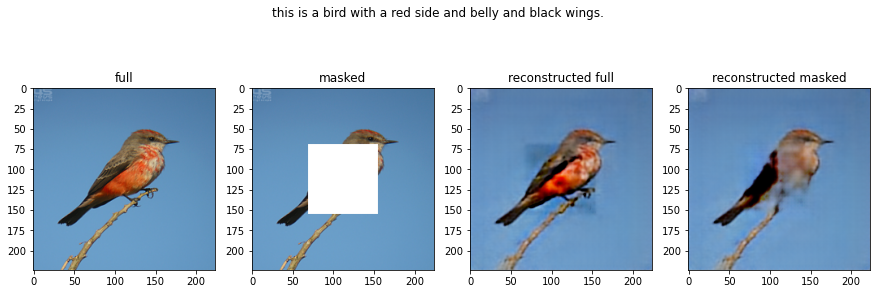

In [14]:
show_checkpoint_repros(model)

In [15]:
dataset_train = CUBDataset('../CUB_200_2011/')

trainloader = DataLoader(dataset_train,
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=8)

2020-11-10 15:33:32.225113 [Epoch 19/20] [Batch 2/1842] [Recon Loss: 0.123018]


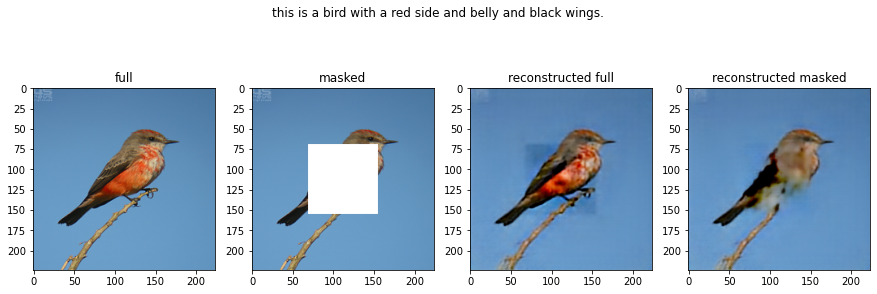

2020-11-10 15:39:23.805405 [Epoch 19/20] [Batch 502/1842] [Recon Loss: 0.153730]


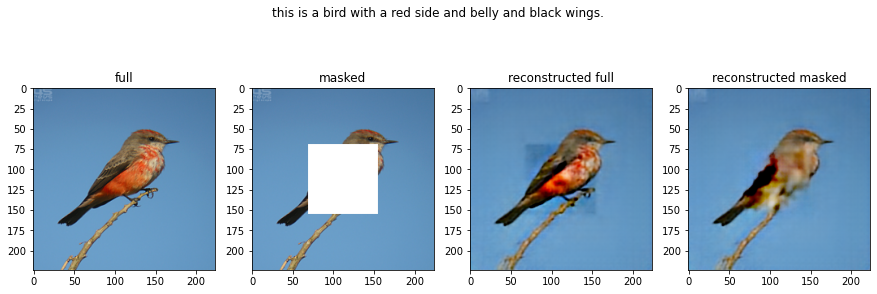

2020-11-10 15:45:28.648773 [Epoch 19/20] [Batch 1002/1842] [Recon Loss: 0.124287]


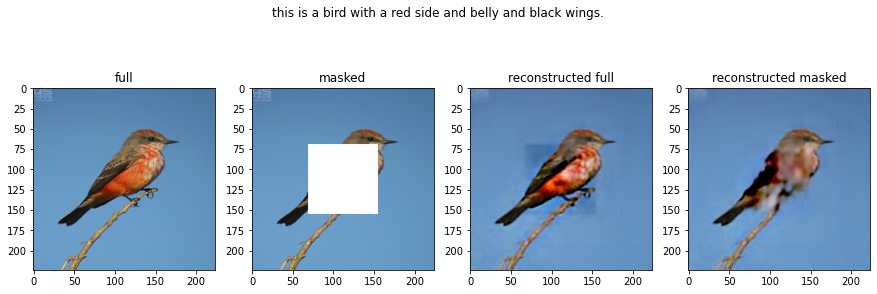

2020-11-10 15:51:49.266620 [Epoch 19/20] [Batch 1502/1842] [Recon Loss: 0.117735]


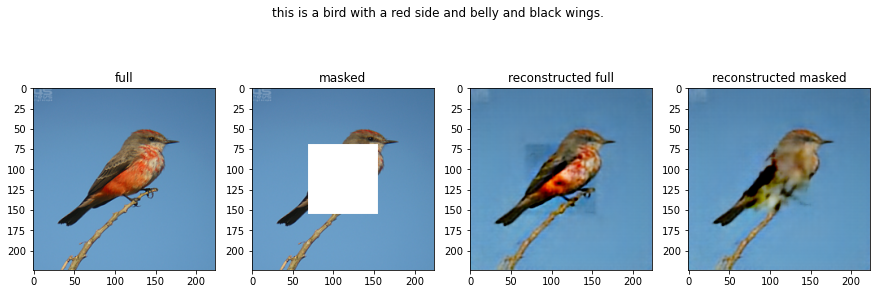


Epoch Loss: 0.002130626035515888


2020-11-10 15:57:34.157104 [Epoch 20/20] [Batch 160/1842] [Recon Loss: 0.145609]


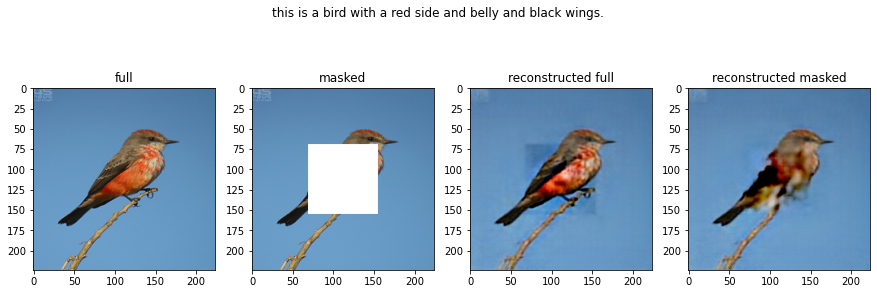

2020-11-10 16:03:09.117754 [Epoch 20/20] [Batch 660/1842] [Recon Loss: 0.166706]


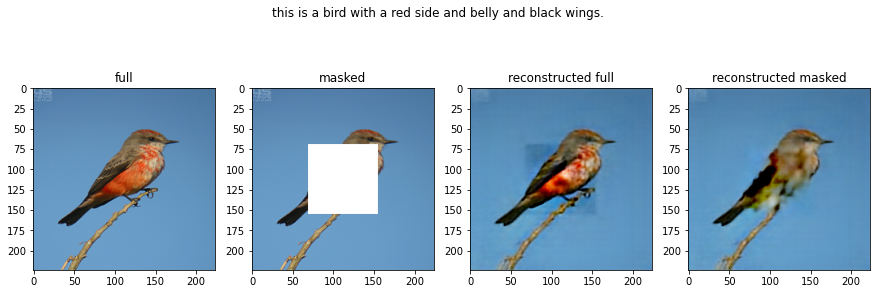

2020-11-10 16:08:46.405918 [Epoch 20/20] [Batch 1160/1842] [Recon Loss: 0.148785]


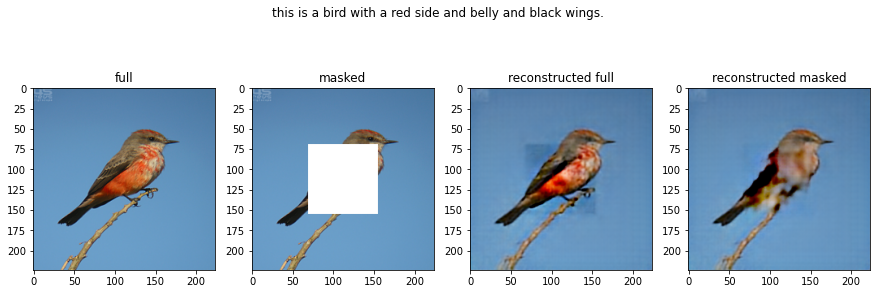

2020-11-10 16:14:27.950468 [Epoch 20/20] [Batch 1660/1842] [Recon Loss: 0.134983]


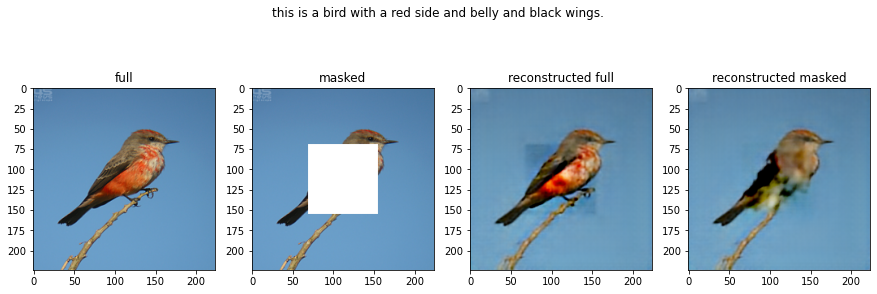


Epoch Loss: 0.00212996609283331


2020-11-10 16:20:15.228541 [Epoch 21/20] [Batch 318/1842] [Recon Loss: 0.122714]


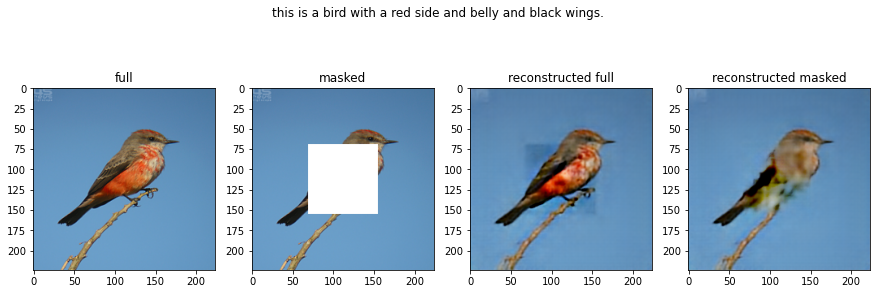

2020-11-10 16:26:10.164864 [Epoch 21/20] [Batch 818/1842] [Recon Loss: 0.148976]


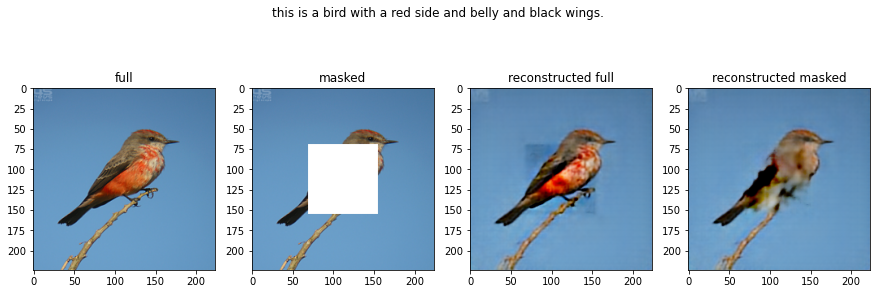

2020-11-10 16:31:59.943948 [Epoch 21/20] [Batch 1318/1842] [Recon Loss: 0.109337]


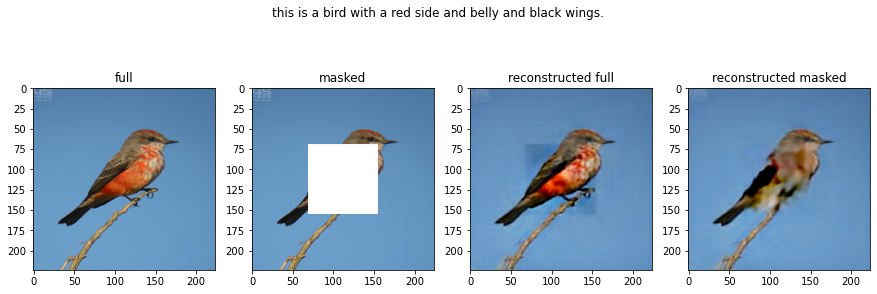

2020-11-10 16:37:48.268355 [Epoch 21/20] [Batch 1818/1842] [Recon Loss: 0.123079]


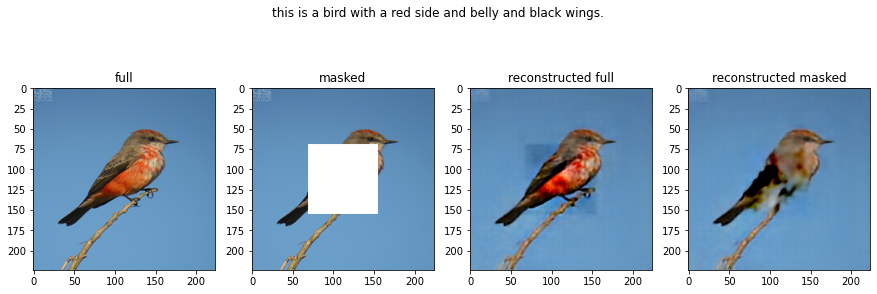


Epoch Loss: 0.0021291027846349108


2020-11-10 16:43:47.936049 [Epoch 22/20] [Batch 476/1842] [Recon Loss: 0.118419]


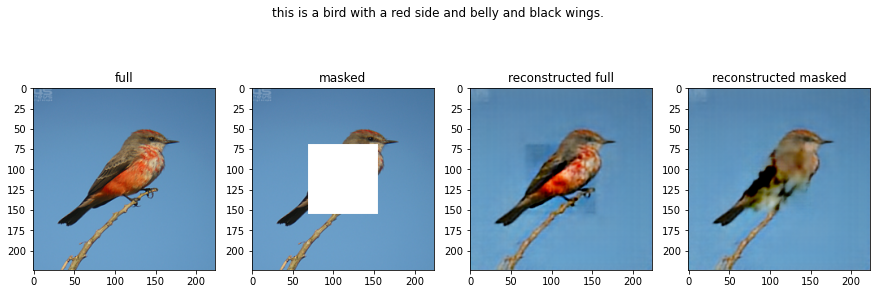

2020-11-10 16:49:49.564785 [Epoch 22/20] [Batch 976/1842] [Recon Loss: 0.161669]


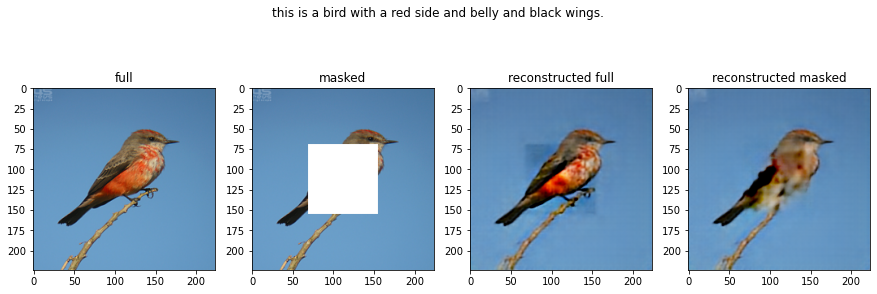

2020-11-10 16:55:44.387328 [Epoch 22/20] [Batch 1476/1842] [Recon Loss: 0.138863]


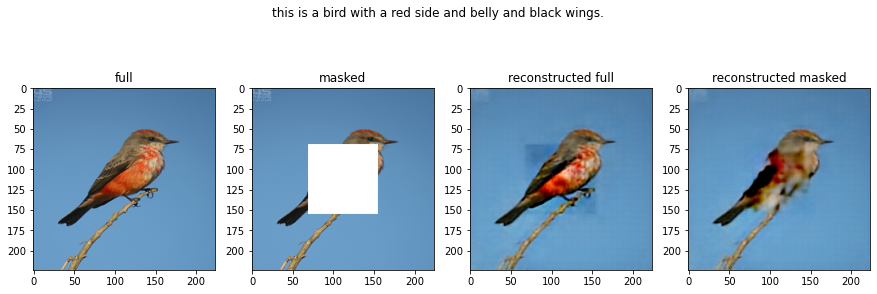


Epoch Loss: 0.0021280810853229826


2020-11-10 17:01:52.371424 [Epoch 23/20] [Batch 134/1842] [Recon Loss: 0.112569]


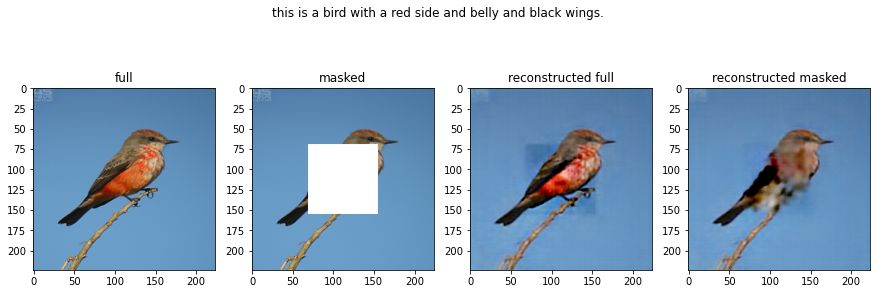

2020-11-10 17:07:48.569325 [Epoch 23/20] [Batch 634/1842] [Recon Loss: 0.108078]


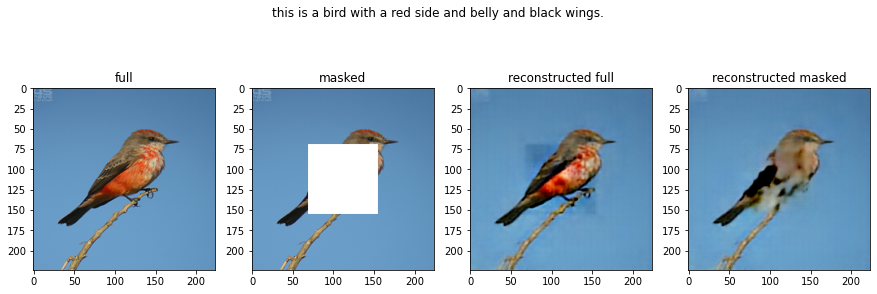

2020-11-10 17:13:49.486021 [Epoch 23/20] [Batch 1134/1842] [Recon Loss: 0.122782]


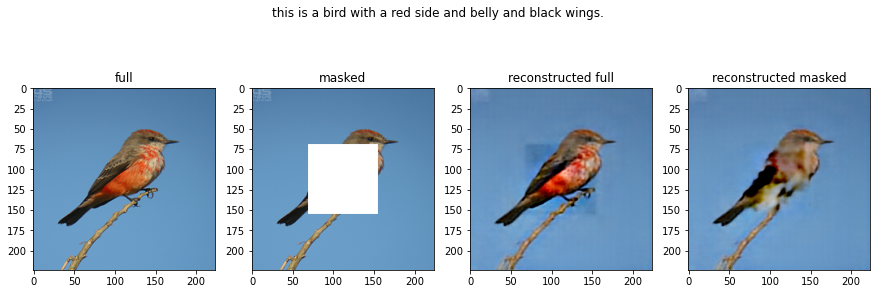

2020-11-10 17:19:56.526654 [Epoch 23/20] [Batch 1634/1842] [Recon Loss: 0.118070]


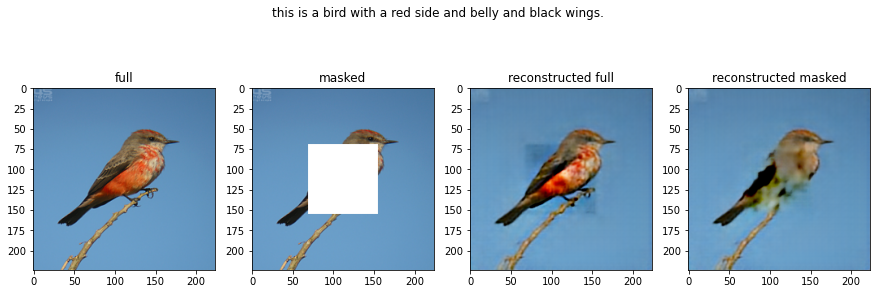


Epoch Loss: 0.0021273005110592274


2020-11-10 17:25:52.448084 [Epoch 24/20] [Batch 292/1842] [Recon Loss: 0.120589]


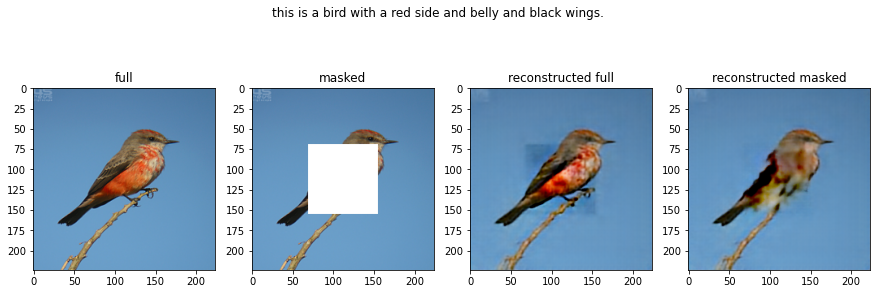

2020-11-10 17:31:49.047163 [Epoch 24/20] [Batch 792/1842] [Recon Loss: 0.143694]


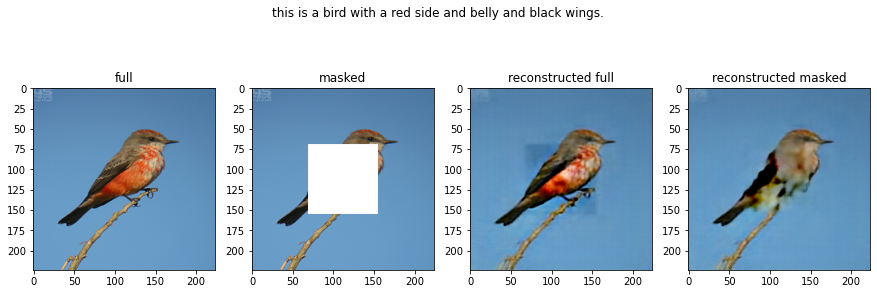

2020-11-10 17:37:45.543293 [Epoch 24/20] [Batch 1292/1842] [Recon Loss: 0.122723]


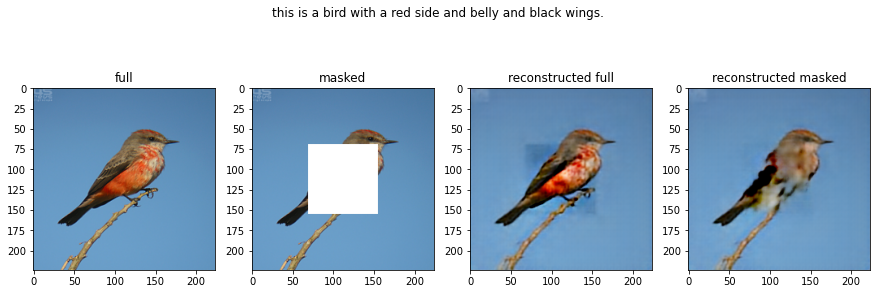

2020-11-10 17:43:43.583176 [Epoch 24/20] [Batch 1792/1842] [Recon Loss: 0.126777]


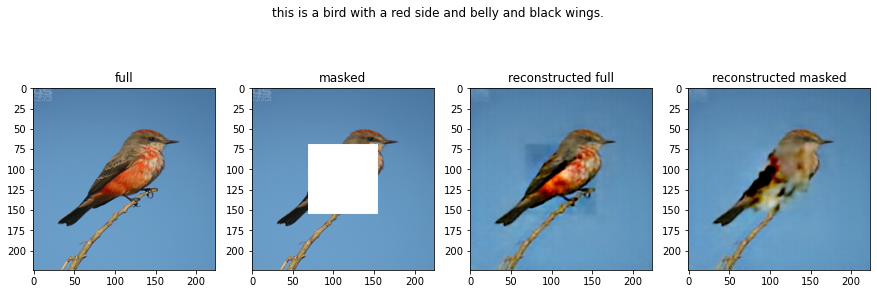


Epoch Loss: 0.0021265217399914736


In [ ]:
# ----------
#  Training
# ----------
# for epoch in tqdm(range(0, stage_1_epochs)):
#     epoch_loss = 0
#     for i, batch in tqdm(enumerate(trainloader), total=(len(dataset_train)//batch_size)):
#         model.train()
        
#         full_imgs = batch['full_images'].cuda()
#         mask = batch['masks']
#         masked_imgs = full_imgs.detach().clone()
        
#         masked_imgs[mask] = 1.0

#         optimizer.zero_grad()

#         # Generate a batch of images
#         gen_imgs = model(full_imgs, tokenize(batch['captions']))

#         #gen_rois = gen_imgs[mask]
#         #full_rois = full_imgs[mask]

#         recon_loss = mse(gen_imgs, full_imgs)
#         epoch_loss+=recon_loss.item()
#         recon_loss.backward()
#         optimizer.step()

#         batches_done = epoch * len(trainloader) + i
#         if batches_done % sample_interval == 0:
#             print(str(datetime.now()), "[Epoch %d/%d] [Batch %d/%d] [Recon Loss: %f]" % (epoch, stage_1_epochs, i, len(trainloader), recon_loss.item()))
#             #save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
#             r_losses.append(recon_loss.item())
#             show_checkpoint_repros(model)
#             pass
#         pass
#     print(f"Epoch Loss: {epoch_loss/len(dataset_train)}")    
#     torch.save(model.state_dict(), f"./checkpoints/text_guided_birbCoAE_epoch_{epoch}_{str(epoch_loss/len(dataset_train))}.pth")
    
    
for epoch in tqdm(range(19, stage_2_epochs+30)):
    epoch_loss = 0
    for i, batch in tqdm(enumerate(trainloader), total=(len(dataset_train)//batch_size)):
        model.train()
        full_imgs = batch['full_images'].cuda()
        mask = batch['masks']
        masked_imgs = full_imgs.detach().clone()
        
        masked_imgs[mask] = 1.0

        optimizer.zero_grad()

        # Generate a batch of images
        gen_imgs = model(masked_imgs, tokenize(batch['captions']))
        
        gen_rois = gen_imgs[mask]
        full_rois = full_imgs[mask]

        recon_loss = mse(gen_imgs, full_imgs)

        recon_loss.backward()
        optimizer.step()
        epoch_loss+=recon_loss.item()
        
        batches_done = epoch * len(trainloader) + i
        if batches_done % sample_interval == 0:
            print(str(datetime.now()), "[Epoch %d/%d] [Batch %d/%d] [Recon Loss: %f]" % (epoch, stage_2_epochs, i, len(trainloader), recon_loss.item()))
            #save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
            r_losses.append(recon_loss.item())
            times.append(time.time())
            show_checkpoint_repros(model)
            pass
        pass
    print(f"Epoch Loss: {epoch_loss/len(dataset_train)}")
    torch.save(model.state_dict(), f"./checkpoints/text_guided_birbCoAE_custom_embedding.pth")